# Week 5

In this lecture we cover some methods for retrieving data from REST APIs, discuss methods model validation and selection techniques, and introduce genetic algorithms. We'll also continue our AWS discussion and introduce the AWS Lambda resource.

**Table of Contents**

-   [Data Preparation](#data-preparation)
    -   [Web APIs](#api)
-   [Model Selection](#selection)
    -   [Validation](#validation)
    -   [Grid Search](#grid)
        -   [Random](#random)
        -   [hyperopt](#hyperopt)
-   [Genetic Algorithm](#genetic)
-   [Model Deployment](#deployment)
    -   [Python pickle](#pickle)
    -   [R save/load](#saveload)

<a id='data-preparation'></a>
## Data Preparation

<a id='api'></a>
### Web APIs

Datasets are not always accessible through databases, or on-disk CSVs, but rather through web-based APIs. This often means that a client can issue an [HTTP](https://en.wikipedia.org/wiki/Hypertext_Transfer_Protocol) request to the API, and expect a response with the desired data in return. We'll take a look at an example of such an API and make some HTTP requests using a python package called `requests`.

The [National Library of Medicine](https://www.nlm.nih.gov/) and the [National Institutes of Health](https://www.nih.gov/) maintain a database of public and privately supported clinical studies on different diseases and conditions. The web interface for this database can be found [ClinicalTrials.gov](https://clinicaltrials.gov/ct2/home). Additional background information can be found [here](https://clinicaltrials.gov/ct2/about-site/background). Fortunately, the team at ClinicalTrials.gov provide programmatic access to the data via a web-based API. Documentation on how to use this API can be found [here](https://clinicaltrials.gov/api/gui/home).

If we wanted to retrieve the first 50 clinical studies involving heart attacks, for example, we could issue the following HTTP request through our browser: `https://clinicaltrials.gov/api/query/full_studies?expr=heart+attack&min_rnk=1&max_rnk=50`.

Alternatively, we could issue the same HTTP request using the python [requests](https://2.python-requests.org/en/master/) package.

In [1]:
import requests

In [2]:
help(requests.get)

Help on function get in module requests.api:

get(url, params=None, **kwargs)
    Sends a GET request.
    
    :param url: URL for the new :class:`Request` object.
    :param params: (optional) Dictionary, list of tuples or bytes to send
        in the body of the :class:`Request`.
    :param \*\*kwargs: Optional arguments that ``request`` takes.
    :return: :class:`Response <Response>` object
    :rtype: requests.Response



In [3]:
response = requests.get('https://clinicaltrials.gov/api/query/full_studies', params={'expr':'heart+attack', 
                                                                                     'min_rnk':'1', 
                                                                                     'max_rnk':'10',
                                                                                     'fmt':'json'})

In [4]:
type(response)

requests.models.Response

In [5]:
response

<Response [200]>

In [7]:
help(requests.models.Response)

Help on class Response in module requests.models:

class Response(builtins.object)
 |  The :class:`Response <Response>` object, which contains a
 |  server's response to an HTTP request.
 |  
 |  Methods defined here:
 |  
 |  __bool__(self)
 |      Returns True if :attr:`status_code` is less than 400.
 |      
 |      This attribute checks if the status code of the response is between
 |      400 and 600 to see if there was a client error or a server error. If
 |      the status code, is between 200 and 400, this will return True. This
 |      is **not** a check to see if the response code is ``200 OK``.
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __getstate__(self)
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |      Allows you to use a response as an iterator.
 |  
 |  __nonzero__(self)
 |      Returns True if :attr:`status_code` is less than 400.
 |      
 |      This attribute checks if 

In [8]:
response.text

'{\n  "FullStudiesResponse":{\n    "APIVrs":"1.01.01",\n    "DataVrs":"2019:08:06 22:51:20.415",\n    "Expression":"heart+attack",\n    "NStudiesAvail":313210,\n    "NStudiesFound":1440,\n    "MinRank":1,\n    "MaxRank":10,\n    "NStudiesReturned":10,\n    "FullStudies":[\n      {\n        "Rank":1,\n        "Study":{\n          "ProtocolSection":{\n            "IdentificationModule":{\n              "NCTId":"NCT00929994",\n              "OrgStudyIdInfo":{\n                "OrgStudyId":"Brooks - 001"\n              },\n              "Organization":{\n                "OrgFullName":"Toronto Rehabilitation Institute",\n                "OrgClass":"OTHER"\n              },\n              "BriefTitle":"Effects of Cardiac Rehabilitation for Individuals With Transient Ischemic Attack",\n              "OfficialTitle":"Effects of Cardiac Rehabilitation for Individuals With Transient Ischemic Attack"\n            },\n            "StatusModule":{\n              "StatusVerifiedDate":"April 2019",\n

We can use the `json_normalize` package to parse the response into a Pandas DataFrame.

In [9]:
import json

response_json = json.loads(response.text)

In [10]:
response_json

{'FullStudiesResponse': {'APIVrs': '1.01.01',
  'DataVrs': '2019:08:06 22:51:20.415',
  'Expression': 'heart+attack',
  'NStudiesAvail': 313210,
  'NStudiesFound': 1440,
  'MinRank': 1,
  'MaxRank': 10,
  'NStudiesReturned': 10,
  'FullStudies': [{'Rank': 1,
    'Study': {'ProtocolSection': {'IdentificationModule': {'NCTId': 'NCT00929994',
       'OrgStudyIdInfo': {'OrgStudyId': 'Brooks - 001'},
       'Organization': {'OrgFullName': 'Toronto Rehabilitation Institute',
        'OrgClass': 'OTHER'},
       'BriefTitle': 'Effects of Cardiac Rehabilitation for Individuals With Transient Ischemic Attack',
       'OfficialTitle': 'Effects of Cardiac Rehabilitation for Individuals With Transient Ischemic Attack'},
      'StatusModule': {'StatusVerifiedDate': 'April 2019',
       'OverallStatus': 'Completed',
       'ExpandedAccessInfo': {'HasExpandedAccess': 'No'},
       'StartDateStruct': {'StartDate': 'March 2010'},
       'PrimaryCompletionDateStruct': {'PrimaryCompletionDate': 'November

In [11]:
from pandas.io.json import json_normalize

df = json_normalize(response_json['FullStudiesResponse']['FullStudies'])
df.head()

,Rank,Study.DerivedSection.ConditionBrowseModule.ConditionAncestorList.ConditionAncestor,Study.DerivedSection.ConditionBrowseModule.ConditionBrowseBranchList.ConditionBrowseBranch,Study.DerivedSection.ConditionBrowseModule.ConditionBrowseLeafList.ConditionBrowseLeaf,Study.DerivedSection.ConditionBrowseModule.ConditionMeshList.ConditionMesh,Study.DerivedSection.InterventionBrowseModule.InterventionBrowseBranchList.InterventionBrowseBranch,Study.DerivedSection.InterventionBrowseModule.InterventionBrowseLeafList.InterventionBrowseLeaf,Study.DerivedSection.MiscInfoModule.VersionHolder,Study.ProtocolSection.ArmsInterventionsModule.ArmGroupList.ArmGroup,Study.ProtocolSection.ArmsInterventionsModule.InterventionList.Intervention,...,Study.ResultsSection.MoreInfoModule.CertainAgreement.AgreementRestrictionType,Study.ResultsSection.MoreInfoModule.CertainAgreement.AgreementRestrictiveAgreement,Study.ResultsSection.MoreInfoModule.LimitationsAndCaveats,Study.ResultsSection.MoreInfoModule.PointOfContact.PointOfContactEMail,Study.ResultsSection.MoreInfoModule.PointOfContact.PointOfContactOrganization,Study.ResultsSection.MoreInfoModule.PointOfContact.PointOfContactPhone,Study.ResultsSection.MoreInfoModule.PointOfContact.PointOfContactTitle,Study.ResultsSection.OutcomeMeasuresModule.OutcomeMeasureList.OutcomeMeasure,Study.ResultsSection.ParticipantFlowModule.FlowGroupList.FlowGroup,Study.ResultsSection.ParticipantFlowModule.FlowPeriodList.FlowPeriod
0,1,"[{'ConditionAncestorId': 'D000010335', 'Condit...","[{'ConditionBrowseBranchAbbrev': 'BC23', 'Cond...","[{'ConditionBrowseLeafId': 'M9126', 'Condition...","[{'ConditionMeshId': 'D000007511', 'ConditionM...",NaN,NaN,"August 07, 2019","[{'ArmGroupLabel': 'Exercise', 'ArmGroupDescri...","[{'InterventionType': 'Behavioral', 'Intervent...",...,NaN,No,This study was conducted in a single centre lo...,dina.brooks@utoronto.ca,Toronto Rehab,4169781739,Dr.,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'FlowGroupId': 'FG000', 'FlowGroupTitle': 'E...","[{'FlowPeriodTitle': 'Overall Study', 'FlowMil..."
1,2,"[{'ConditionAncestorId': 'D000010335', 'Condit...","[{'ConditionBrowseBranchAbbrev': 'BC10', 'Cond...","[{'ConditionBrowseLeafId': 'M20890', 'Conditio...","[{'ConditionMeshId': 'D000007511', 'ConditionM...",NaN,NaN,"August 07, 2019","[{'ArmGroupLabel': 'Usual Care', 'ArmGroupType...","[{'InterventionType': 'Behavioral', 'Intervent...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,"[{'ConditionAncestorId': 'D000002318', 'Condit...","[{'ConditionBrowseBranchAbbrev': 'BC14', 'Cond...","[{'ConditionBrowseLeafId': 'M10737', 'Conditio...","[{'ConditionMeshId': 'D000006333', 'ConditionM...",NaN,NaN,"August 07, 2019",NaN,"[{'InterventionType': 'Drug', 'InterventionNam...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"[{'ConditionAncestorId': 'D000006331', 'Condit...","[{'ConditionBrowseBranchAbbrev': 'BC14', 'Cond...","[{'ConditionBrowseLeafId': 'M8004', 'Condition...","[{'ConditionMeshId': 'D000006333', 'ConditionM...",NaN,NaN,"August 07, 2019","[{'ArmGroupLabel': 'PG-116800 tablet', 'ArmGro...","[{'InterventionType': 'Drug', 'InterventionNam...",...,OTHER,Yes,NaN,thomas.pr@pg.com,Procter & Gamble,513.622.4838,Peter Thomas,"[{'OutcomeMeasureType': 'Primary', 'OutcomeMea...","[{'FlowGroupId': 'FG000', 'FlowGroupTitle': 'P...","[{'FlowPeriodTitle': 'Overall Study', 'FlowMil..."
4,5,"[{'ConditionAncestorId': 'D000017202', 'Condit...","[{'ConditionBrowseBranchAbbrev': 'BC14', 'Cond...","[{'ConditionBrowseLeafId': 'M10738', 'Conditio...","[{'ConditionMeshId': 'D000002318', 'ConditionM...",NaN,NaN,"August 07, 2019","[{'ArmGroupLabel': 'Standard care', 'ArmGroupT...","[{'InterventionType': 'Behavioral', 'Intervent...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
list(df.columns)

['Rank',
 'Study.DerivedSection.ConditionBrowseModule.ConditionAncestorList.ConditionAncestor',
 'Study.DerivedSection.ConditionBrowseModule.ConditionBrowseBranchList.ConditionBrowseBranch',
 'Study.DerivedSection.ConditionBrowseModule.ConditionBrowseLeafList.ConditionBrowseLeaf',
 'Study.DerivedSection.ConditionBrowseModule.ConditionMeshList.ConditionMesh',
 'Study.DerivedSection.InterventionBrowseModule.InterventionBrowseBranchList.InterventionBrowseBranch',
 'Study.DerivedSection.InterventionBrowseModule.InterventionBrowseLeafList.InterventionBrowseLeaf',
 'Study.DerivedSection.MiscInfoModule.VersionHolder',
 'Study.ProtocolSection.ArmsInterventionsModule.ArmGroupList.ArmGroup',
 'Study.ProtocolSection.ArmsInterventionsModule.InterventionList.Intervention',
 'Study.ProtocolSection.ConditionsModule.ConditionList.Condition',
 'Study.ProtocolSection.ConditionsModule.KeywordList.Keyword',
 'Study.ProtocolSection.ContactsLocationsModule.CentralContactList.CentralContact',
 'Study.Protoco

In [13]:
use_cols = ['Study.ProtocolSection.StatusModule.OverallStatus',
            'Study.ProtocolSection.StatusModule.StartDateStruct.StartDate',
            'Study.ProtocolSection.EligibilityModule.MaximumAge',
            'Study.ProtocolSection.EligibilityModule.MinimumAge',
            'Study.ProtocolSection.DesignModule.EnrollmentInfo.EnrollmentType',
            'Study.ProtocolSection.DesignModule.EnrollmentInfo.EnrollmentCount',
            'Study.ProtocolSection.DescriptionModule.DetailedDescription',
            'Study.ProtocolSection.DescriptionModule.BriefSummary']

In [14]:
df_use = df[use_cols]

In [15]:
df_use.columns = ['OverallStatus',
                  'StartDate',
                  'MaximumAge',
                  'MinimumAge',
                  'EnrollmentType',
                  'EnrollmentCount',
                  'DetailedDescription',
                  'BriefSummary']

In [16]:
df_use.head()

,OverallStatus,StartDate,MaximumAge,MinimumAge,EnrollmentType,EnrollmentCount,DetailedDescription,BriefSummary
0,Completed,March 2010,100 Years,18 Years,Actual,20,A transient ischemic attack (TIA) is defined a...,It is hypothesized that the addition of formal...
1,Unknown status,September 2007,NaN,20 Years,Anticipated,200,Similar risk factors predispose patients to bo...,"The purpose of this study is to determine, in ..."
2,Terminated,November 2002,80 Years,18 Years,NaN,NaN,NaN,Study to examine the safety and effectiveness ...
3,Completed,September 2003,80 Years,18 Years,Actual,253,Heart attacks cause damage to heart muscle tha...,The main purpose of the study is to test wheth...
4,Completed,June 2013,74 Years,40 Years,Actual,402,Heart Attack Prevention Programme for You Lond...,"Diseases of the heart and blood vessels, such ..."


In [17]:
df_use.isna().sum()

OverallStatus          0
StartDate              0
MaximumAge             3
MinimumAge             1
EnrollmentType         1
EnrollmentCount        1
DetailedDescription    2
BriefSummary           0
dtype: int64

[httr](https://cran.r-project.org/web/packages/httr/vignettes/quickstart.html) is an R library for making HTTP requests.

<a id='selection'></a>
## Model Selection

Models are certainly wrong, but some models are better than others. We'll discuss why models are wrong, in general, and then cover some methods for selecting a model. 

Models are often wrong because there is some randomness associated with the phenomenon being modeled. Models can also be wrong because they are constructed with incomplete or imperfect information. Model "wrongness" based on these factors is generally considered *irreducible*. 

Models can also be wrong because of choices made by the modeler. The modeler may construct an overly *simple* model, which fails to capture the trend in the phenomena. For example, let's say we have a process that generated the following data.

```
> x <- runif(15, 0, 10)
> y <- jitter(-(x-5)^2+20, amount = 4)
> plot(x,y, col="blue")
```

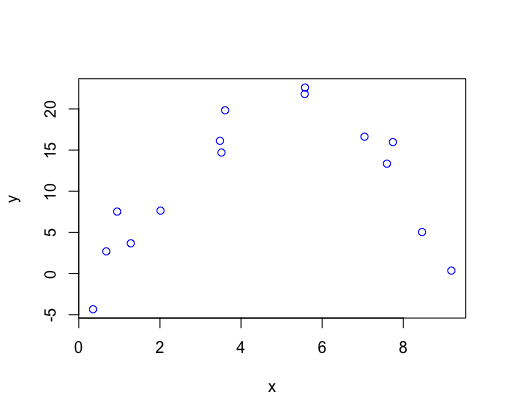

In [18]:
from IPython.display import Image
Image(filename='x-y.png') 

A simple model might be the *average*:

```
> mean(y)
[1] 10.90919
> abline(h=10.90919, col="red")
```

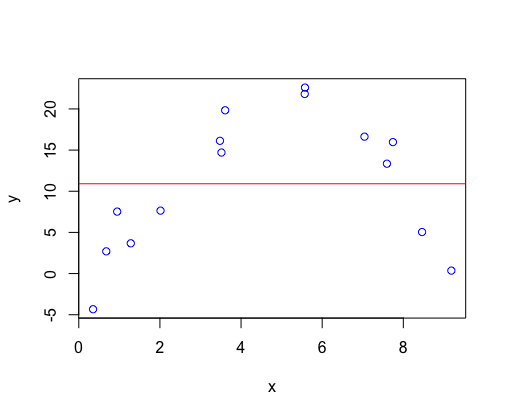

In [19]:
Image(filename='mean.png') 

We can compute the sum of squared errors: 

```
> sum((y-10.90919)^2)
[1] 960.8825
```

Alternatively, a *complex* model could be a 14-degree polynomial that fits the training data perfectly. 

```
> fit <- lm( y~poly(x,14) )
> sum((y-predict(fit, data.frame(x)))^2)
[1] 5.533051e-19
```

Let's look at the parameters of the linear model.

```
> fit$coefficients
  (Intercept)  poly(x, 14)1  poly(x, 14)2  poly(x, 14)3  poly(x, 14)4  poly(x, 14)5  poly(x, 14)6  poly(x, 14)7 
  10.90919237    9.73502677  -27.82637815   -4.65545952    0.23852823    3.52830486   -2.60896570    4.34252269 
 poly(x, 14)8  poly(x, 14)9 poly(x, 14)10 poly(x, 14)11 poly(x, 14)12 poly(x, 14)13 poly(x, 14)14 
   1.30515838    2.11872032    0.21322518    0.26083368    4.64260819   -0.09616936   -2.02289389
```

Here's a plot of the 14-degree polynomial

```
> newdata <- data.frame(x=seq(0, 10, .01))
> newdata$pred <- predict(fit, newdata)
> lines(newdata$x, newdata$pred, col = "red")
```

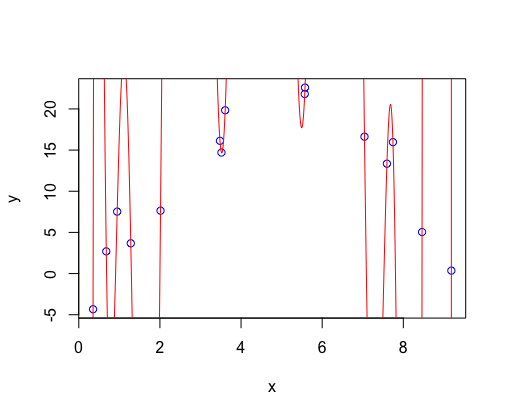

In [20]:
Image(filename='polynomial-fit.png') 

In this example, we say the first model is *biased*, compared with the second model. In other words, the first model doesn't capture the quadratic trend of the phenomenon. As a result, its prediction quality is poor. 

The second model, on the other hand, is not biased. It captures the trend perfectly.

Let's draw a new sample from the quadratic process and see what the first modeling technique produces for a model. 

```
> x2 <- runif(15, 0, 10)
> y2 <- jitter(-(x2-5)^2+20, amount = 4)
> mean(y2)
[1] 10.63482
```

We can see that given new sampling from the process, the model is about the same. In other words, this modeling technique (i.e. taking the average) exhibits low *variance*.

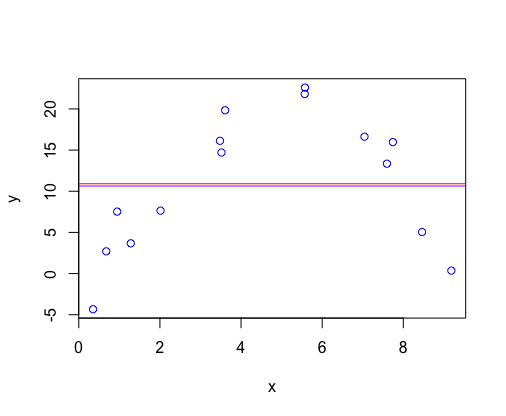

In [21]:
Image(filename='low-variance.png') 

Now, let's see what the second modeling technique produces for a model.

```
> fit2 <- lm( y2~poly(x2,14) )
> fit2$coefficients
   (Intercept)  poly(x2, 14)1  poly(x2, 14)2  poly(x2, 14)3  poly(x2, 14)4  poly(x2, 14)5  poly(x2, 14)6 
   10.63482176     6.35825984   -34.09351591    -0.32834567     0.63546842     0.93658839     4.57100111 
 poly(x2, 14)7  poly(x2, 14)8  poly(x2, 14)9 poly(x2, 14)10 poly(x2, 14)11 poly(x2, 14)12 poly(x2, 14)13 
    0.12489547     0.04060883     2.43208932    -3.12143017     1.67683497     3.53988539     0.76185077 
poly(x2, 14)14 
    0.12660174 
```

This model is drastically different from the original model, given a new sample of training data. This modeling technique exhibits high *variance*.

```
> newdata2 <- data.frame(x2=seq(0, 10, .01))
> newdata2$pred <- predict(fit2, newdata2)
> lines(newdata2$x2, newdata2$pred, col = "purple")
```

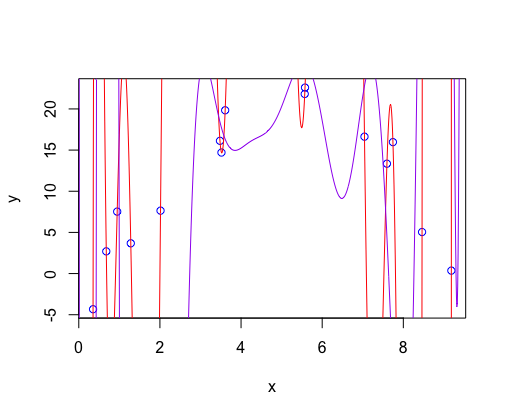

In [22]:
Image(filename='polynomial-2.png') 

Let's see how both of the original models perform on test data. We can use the second sample as test data for the first models. 

```
> sum((y2-10.90919)^2)
[1] 1257.822
> sum((y2-predict(fit, data.frame(x=x2)))^2)
[1] 934041004
```

We can see the both of the models fit the test data pretty poorly. However, the first modeling technique *under-fits* the training data, and the second modeling technique *over-fits* the training data. Neither technique extrapolates very well to new data.

There are different definitions of model *complexity*. And, as we saw in our Neural Networks lecture, there are ways to penalize the model for complexity with regularization. In general, though, we can say that as the number of *parameters* of a model increases, the model becomes more complex. There's a danger of over-fitting with overly complex models. There's a danger of under-fitting with overly simple models. The goal of model selection is to pick a model that neither under-fits or over-fits the training data. There are number of techniques that we can use to strike this balance, which we will discuss next.

<a id='validation'></a>
### Validation

How "good" is your trained model? There are numerous measures of "goodness". For regression problems it's common to use the sum of squared differences between the actual and predicted values. In other words $\sum\limits_{i=1}^{N}(y_i-\hat{y_i})^2$. Sometimes this value is divided by $N$, in which case it is the *mean-squared error*, or MSE. 

If you compute the MSE on the same set that you trained the model, you may get the impression that your model is better than it actually is. It's better to evaluate your model on a set of data that wasn't trained on. A portion of the original training data (usually < 50%) can be set aside for *validation*. This portion can be selected at random, without replacement. 

Sometimes, the *cross-validation* technique is preferred when determining how good a model is, or how well it will generalize to new data. In this technique, the observations can be split into N *folds*. N=3 or N=10 are typical choices. Then, for each fold, the remaining N-1 folds are used to train the model. The model is evaluated on the single fold that was not used to train. The average metric (i.e. MSE) across all N folds is used as the final score. 

There are many metrics by which to evaluate a model. For binary classification problems, for example, area under the curve (AUC) is a probability-threshold-independent measure. There are also a number of measures based on a the confusion matrix values for a specified probability threshold, such as precision, recall, fall-out, accuracy, and F1 scores.

<a id='grid'></a>
### Grid Search

The validation techniques introduces above are performed for a given set of model *hyper-parameters*. Here, we distinguish between model *parameters* and model *hyper-parameters*. Model parameters are the things that are learned by the algorithm. For example, in decision trees, the model parameters are the splitting features and values chosen at each node in the tree. For neural networks, the parameters are the weights. In linear regression, the model parameters are the coefficients. Model hyper-parameters are the inputs to the modeling algorithm that have an effect on the model that is produced, but are provided by the user, and are not learned. For example, in random forest, the number of trees to construct, the maximum tree depth, and the number of features to consider at a given node for splitting, are all model hyper-parameters. For neural networks, the learning rate is a hyper-parameter. 

The choice of hyper-parameters can certainly effect the structure of the model and how good it is. One set of hyper-parameters might be better than another set. So, how do you find the best set of hyper-parameters? Well, you can conduct a search over the hyper-parameter space. We'll go over a few search techniques in this section.  

<a id='random'></a>
#### Random

On approach to searching the hyper-parameter space for good sets of hyper-parameters (i.e. ones that result in a model that has a relatively small validation metric) is a random search. In this approach, random permutations of the possible hyper-parameter values are generated. How many permutations should be generated? It's up to you. How much time do you have? Clearly, in the end, you pick the set of hyper-parameters that resulted in the best validation metric.

<a id='hyperopt'></a>
#### hyperopt

Searching the hyper-parameter space for the best set of values can be framed as an optimization problem, where the objective function is the validation metric, which we are attempting to maximize or minimize. There are probably a ton of optimization techniques out there that are appropriate for this task. [hyperopt](https://github.com/hyperopt/hyperopt) is a python package that implements an optimization approach to finding the best hyper-parameters. For more information on the theory behind hyperopt, [here's](http://proceedings.mlr.press/v28/bergstra13.pdf) the paper.

Here's a quick demonstration of how you can use the hyperopt package for searching for a good set of hyper-parameters for a random forest model.

First, let's define our random forest model using the scikit learn package and the example provided in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
import numpy as np

X, y = make_classification(n_samples=1000, 
                           n_features=4, 
                           n_informative=2, 
                           n_redundant=0, 
                           random_state=0, 
                           shuffle=False)

In [24]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

First, let's define the hyper-parameter space we'd like to search over. For demonstration purposes, we'll keep this pretty small.

In [25]:
hspace = {
          'max_depth': hp.quniform("max_depth", 2, 5, 1),
          'n_estimators': hp.quniform ('n_estimators', 5, 10, 1),
         }

Let's define the objective function that we want to minimize.

In [26]:
def objective(hspace):
    clf = RandomForestClassifier(n_estimators=int(hspace['n_estimators']), max_depth=int(hspace['max_depth']))

    accuracy = np.mean(cross_val_score(clf, X, y, cv=10))

    return{'loss':-accuracy, 'status': STATUS_OK, 'model': clf }

Here, we used the [cross_val_score](https://scikit-learn.org/stable/modules/cross_validation.html) function to compute 10-fold cross validation score (accuracy). Notice that hyperopt attempts to minimize the objective function. We want the maximum accuracy, so we multiply the loss by -1. 

Next, we call the hyperopt `fmin` function to kick off the search.

In [27]:
trials = Trials()
best = fmin(fn=objective,
            space=hspace,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

100%|██████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.72it/s, best loss: -0.9498359835983597]


Let's take a look at the various trials.

In [28]:
trials.losses()

[-0.9457955795579558,
 -0.9387648764876488,
 -0.9498359835983597,
 -0.9398050805080507,
 -0.9478256825682569,
 -0.9397850785078509,
 -0.9397650765076507,
 -0.9407951795179518,
 -0.9387848784878488,
 -0.9427751775177518]

In [29]:
best

{'max_depth': 4.0, 'n_estimators': 9.0}

In [30]:
trials.results[3]

{'loss': -0.9398050805080507,
 'status': 'ok',
 'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=2, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False)}

In [31]:
best_model = trials.results[3]['model']
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

How would you do the same process in R?

<a id='genetic'></a>
## Genetic Algorithm

The [genetic algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) is an optimization technique inspired by the process of natural selection. The algorithm begins with a *population* of candidate solutions, or *individuals*. A solution is represented as sequence of bits, where each bit position is a feature. For a given individual, a bit is given a value of 1 if that feature is expressed in the individual, and a 0 otherwise. Given an initial population, the genetic algorithm evaluates the *fitness*, or objective function, for each individual. Some of the better solutions are selected and modified (*crossover* and *mutation*) to produce a new population, or *generation*. This process is iterated until some solution fitness level is achieved, or the maximum number of iterations is reached.

There are a number of aspects that must be considered when implementing or executing a genetic algorithm. 

How should the population for a genetic algorithm be initialized? One technique is to randomly generate the population from range of possible solutions. Of course, you must also choose the size of initial population. 

How should a solution to your problem be encoded? Let's say we wanted to optimize the cross-validation score for a random forest model over the hyper-parameters max tree depth, number of trees, and the minimum number of node observations. First, you could limit the range of possible value for a given feature. For example, we could limit the range of number of trees from 1 to 1000. We could encode values in this range with 10 bits. Limiting the range of max depth from 1-10 means we could encode these values in 4 bits. Limiting the minimum observations from 1 - 20 means we could encode these values in 5 bits. Overall, a given solution could be represented as a 19-bit value. Of course, some encoding would not be valid, and the algorithms would have to check for these.

How many candidates should be selected once their fitnesses have been computed? 

Once the candidates have been selected, how should the new generation be produced? *Crossover* and *Mutation* are a couple common approaches. In the crossover process, two *parent* individuals are considered, and the new individual is created by taking a portion of the solution from one parent and combining it with the left-out portion from the other parent. Once this is completed, you can also randomly change some of the bit values of resulting individual. This is called mutation.  

There are a number of packages that implement the genetic algorithm. In R, the [GA](https://cran.r-project.org/web/packages/GA/) package is such an implementation. If we look at its documentation we can see that it allows you to specify a lot of the above considerations.

<a id='deployment'></a>
## Model Deployment

Once you've developed your model, you might want to deploy it as part of an application. If you've developed your model in R, then the model could fit nicely into and [R Shiny](https://shiny.rstudio.com/) application, for example. If you've developed your model in python, then perhaps a python application is best. If you use H2O, then you can export your model as a Java object, for use in Java applications. 

In any case, in order to "hand off" the model to the production environment, it should be persisted to disk, or saved. The saved model can then be ingested by the application, where it can be used to make predictions. We'll go over how to do this in both python and R.

<a id='pickle'></a>
### Python pickle

The [pickle](https://docs.python.org/2/library/pickle.html) package can be used to serialize and deserialize python objects, including models. Here's an example of saving and loading the random forest model we constructed in the above hyperopt example. 

In [32]:
import pickle
with open('rf.pkl', 'wb') as mf:
    pickle.dump(best_model,mf)

In [33]:
with open('rf.pkl', 'rb') as mf:
    rf = pickle.load(mf)

In [34]:
rf.fit(X, y)
rf.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Other (de)serialization packages exist, such as [joblib](https://joblib.readthedocs.io/en/latest/persistence.html).

<a id='saveload'></a>
### R save/load

We can use the `save()` and `load()` functions in R to accomplish the same thing.

```R
library(randomForest)
rf <- randomForest(Species ~ ., data=iris)
save(rf,file = "rf.RData")
rm(rf)
load("rf.RData")
predict(rf, iris)
```

What if your application is written in a different language than your model object?